# Nasdaq Exploration Analysis

Main focuses
- first look at the dataset
- categorizing by sector
- choosing indicators which will help evaluate stocks
- clustering the stocks


In [79]:
import sklearn.cluster
import sklearn.mixture
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.decomposition

import matplotlib.pyplot as plt
import matplotlib
import seaborn
import pandas
import numpy
import os

seaborn.set_theme()
seaborn.set(rc={'figure.figsize':(14, 6)})

### Loading data
there are around 5800 csv files the loading takes quite a while


In [84]:
NOF_TRADING_DAYS = 252

metadata = pandas.read_csv("symbols_meta.csv")
screener = pandas.read_csv("nasdaq_screener.csv")
stocks_dir = os.path.join(os.getcwd(), "stocks")
dir_list = os.listdir(stocks_dir)
nasdaq_symbols = []


stocks = {}
for file in dir_list:
    symbol = file.strip(".csv")
    nasdaq_symbols.append(symbol)
    stocks[symbol] = pandas.read_csv(f"stocks/{file}")
    stocks[symbol]['TimeStamp'] = pandas.to_datetime(stocks[symbol]['Date'],format= '%Y-%m-%d')
    stocks[symbol].drop(columns=['Date'],inplace=True)

In [81]:
def get_period(start, end):
    valid = {}  # stocks which were active during selected period
    nof_days = {}  # frequency of the number of records 

    for sym in nasdaq_symbols:
        start_date = stocks[sym]['TimeStamp'].min()
        end_date = stocks[sym]['TimeStamp'].max()

        if start_date <= start and end_date >= end:
            trimmed = stocks[sym][(stocks[sym]['TimeStamp'] >= start) & (stocks[sym]['TimeStamp'] <= end)]
            valid[sym] = trimmed
            recs = len(valid[sym])

            if recs in nof_days: nof_days[recs] += 1
            else: nof_days[recs] = 0

    # remove stocks which have missing data
    desired_nof_records = max(nof_days, key=nof_days.get)
    valid = {k:v for k, v in valid.items() if len(v) == desired_nof_records}
    return valid

In [85]:
period_start = pandas.to_datetime("2017-01-01" ,format= '%Y-%m-%d')
period_end = pandas.to_datetime("2019-01-01" ,format= '%Y-%m-%d')

stocks = get_period(period_start, period_end)
stock_symbols = list(stocks.keys())
print(f"Number of selected stocks: {len(stock_symbols)}")
print(f"Columns of the stocks: {list(stocks[stock_symbols[0]].columns)}")

Number of selected stocks: 4704
Columns of the stocks: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'TimeStamp']


In [86]:
stocks[stock_symbols[0]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502 entries, 3386 to 3887
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       502 non-null    float64       
 1   High       502 non-null    float64       
 2   Low        502 non-null    float64       
 3   Close      502 non-null    float64       
 4   Adj Close  502 non-null    float64       
 5   Volume     502 non-null    int64         
 6   TimeStamp  502 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 31.4 KB


In [87]:
stocks[stock_symbols[0]].describe()

,Open,High,Low,Close,Adj Close,Volume
count,502.000000,502.000000,502.000000,502.000000,502.000000,5.020000e+02
mean,21.558068,21.882888,21.223347,21.555199,21.555199,4.276036e+05
std,2.855076,2.892146,2.811013,2.847689,2.847689,3.015436e+05
min,15.010000,15.370000,14.970000,14.990000,14.990000,1.003000e+05
25%,20.012500,20.430000,19.480000,20.050001,20.050001,2.495250e+05
50%,22.485000,22.790000,22.030001,22.420000,22.420000,3.446000e+05
75%,23.630000,23.945001,23.317500,23.650000,23.650000,5.053250e+05
max,27.129999,27.670000,26.549999,27.070000,27.070000,2.528500e+06


### Categorizing stocks by sector

The stocks could be categorized in the following:
- **Industrials**: The industrials sector encompasses a wide range of different businesses that generally involve the use of heavy equipment. Transportation stocks such as airlines, railroads, and logistics companies are found within the industrials sector, as are companies in the aerospace, defense, construction, and engineering industries. Companies making building products, electrical equipment, and machinery also fall into this sector, as do many conglomerates.
- **Real Estate**: The real estate sector generally includes two different types of investments related to real estate. Some stocks in the sector are responsible for developing new real estate projects and then managing them by obtaining tenants for various spaces within the project property. In addition, most real estate investment trusts, which are special tax-favored business entities that operate in various areas of the real estate industry, get counted as within the real estate sector.
- **Basic Materials**: The materials sector includes companies that provide various goods for use in manufacturing and other applications. You'll find makers of chemicals, construction materials, and containers and packaging within the materials sector, along with mining stocks and companies specializing in making paper and forest products.
- **Finance**: The financials sector includes businesses that are primarily related to handling money. Banks are a key industry group within the sector, but you'll also find insurance companies, brokerage houses, consumer finance providers, and mortgage-related real estate investment trusts among financials.
- **Energy**: The energy sector covers companies that do business in the oil and natural gas industry. It includes oil and gas exploration and production companies, as well as producers of other consumable fuels like coal and ethanol. The energy sector also includes the related businesses that provide equipment, materials, and services to oil and gas producers. Oddly enough, though, it doesn't include many renewable energy companies, which instead are considered utilities.
- **Utilities**: The utilities sector encompasses just about every different type of utility company you can think of. Within the sector, you'll find utilities specializing in making electrical power available to residential and commercial customers, as well as specialists in natural gas transmission and distribution. Other utilities are responsible for delivering water to customers. Some utility companies engage in more than one of these different subspecialties. In addition, independent producers of power and renewable electricity also land in the utilities sector, even though they don't exactly resemble the traditional regulated utility in an era of deregulation.
- **Consumer Staples**: The consumer staples sector includes goods and services that consumers need, regardless of their current financial condition. The category includes companies in the food, beverage, and tobacco industries, as well as household and personal care products. You'll also find retail companies that specialize in selling staples, such as supermarkets, in this group.
- **Consumer Discretionary**: The consumer discretionary sector covers goods and services for which consumer demand depends upon consumer financial status. For example, if you make $25,000 per year, you probably buy a different car than someone who makes $25 million per year. The sector includes companies that sell higher-priced items like automobiles and luxury goods, as well as leisure products. You'll find both brick-and-mortar and e-commerce-based retail companies in this category, along with hotel and restaurant stocks.
- **Telecommunications**: The communication services sector is the newest of the GICS sectors and includes a couple of major areas that used to be part of other sectors. Telecommunication services providers, including both wireless telecom networks and providers of old-style landline services, make up one wing of the sector. At the other end are media and entertainment companies, including both older media like television and radio and interactive media via the internet and newer forms of communication.
- **Health Care**: The healthcare sector has two primary components. One component includes companies that develop pharmaceuticals and treatments based on biotechnology, as well as the analytical tools and supplies needed for the clinical trials that test those treatments. The other encompasses healthcare equipment and services, including surgical supplies, medical diagnostic tools, and health insurance.
- **Technology**: The information technology sector covers companies involved in the different categories of technological innovation. Some companies in information technology focus on creating software or providing services related to implementing technological solutions, while others are more involved in building the equipment, components, and hardware that make tech possible. Information technology also includes makers of semiconductors and the’’ equipment used to produce semiconductor chips.
- **Miscellaneous**: All that remains
- **NaNs**: which I excluded from the set

In [88]:
screener = pandas.read_csv("nasdaq_screener.csv")
# nan != nan
mapping = {s:[] for s in set(screener['Sector']) if s == s}

for sym in stock_symbols:
    sector = screener[screener['Symbol'] == sym]['Sector'].values
    
    if len(sector) > 0 and isinstance(sector[0], str): 
        mapping[sector[0]].append(sym)

sector_names = mapping.keys()
time_stamps = stocks[stock_symbols[0]]['TimeStamp'].to_list()

Now that we have categorized stocks into the sectors we can sum up stock prices for each sector.

,Health Care,Technology,Telecommunications,Consumer Discretionary,Energy,Industrials,Utilities,Consumer Staples,Miscellaneous,Basic Materials,Real Estate,Finance
TimeStamps,,,,,,,,,,,,
2017-01-03,32692.285239,212113.898857,1146.244006,8.473012e+06,1.020126e+06,19553.977678,4495.052865,4196.770787,512.139993,658.211674,7289.109696,54485.408352
2017-01-04,33625.948748,211431.668442,1161.229306,8.654535e+06,9.967364e+05,19950.825117,4532.289188,4226.181981,519.959999,679.414998,7398.774551,30056.552469
2017-01-05,33340.488125,213036.728370,1161.753237,8.798008e+06,9.576868e+05,19669.098139,4524.609332,4200.812534,513.550006,678.543343,7401.933468,53695.588095
2017-01-06,33045.611079,210655.937984,1155.195879,8.868818e+06,8.795500e+05,19593.069069,4524.328270,4182.871346,513.599996,667.189994,7389.966946,29863.127837
2017-01-09,33353.778209,217137.771121,1152.832030,8.507801e+06,7.935418e+05,19322.959490,4460.839341,4149.790680,506.700000,669.873330,7327.097671,53351.708641
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,17343.171246,16390.046265,927.169998,3.211213e+04,5.730083e+03,18119.398288,4666.628347,3619.655010,460.859998,474.300994,6583.318699,26526.518924
2018-12-26,18204.246051,17261.811965,959.449996,3.368281e+04,5.919065e+03,18691.505699,4763.656106,3709.951995,479.259998,489.364995,6801.139435,27421.384364
2018-12-27,18303.518453,17453.412731,959.540005,3.382866e+04,5.297416e+03,18873.716636,4791.971377,3717.379985,483.499999,491.250003,6793.708960,27517.439633


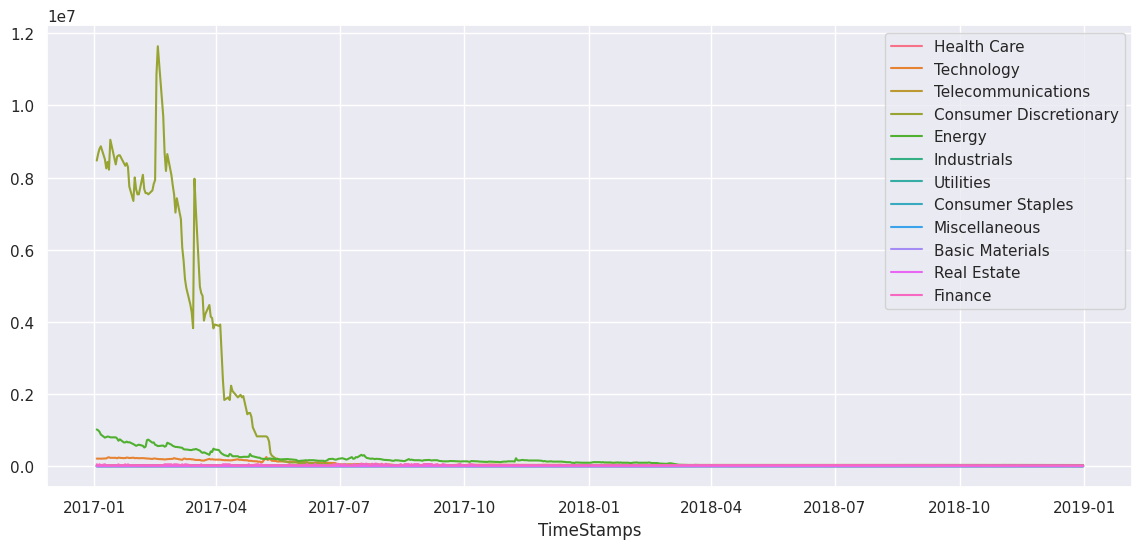

In [89]:
df_industry = pandas.DataFrame(columns=list(mapping.keys()))

for i, sec in enumerate(sector_names):
    industry_dict = {s:stocks[s]['Close'].tolist() for s in mapping[sec]}
    industry = pandas.DataFrame.from_dict(industry_dict)

    df_industry[sec] = industry.sum(axis=1)


df_industry['TimeStamps'] = time_stamps
df_industry = df_industry.set_index('TimeStamps')
fig = seaborn.lineplot(data=df_industry, dashes=False)
df_industry

We cannot deduce much from the plot now. Let's centralize stock prices and normalize them.

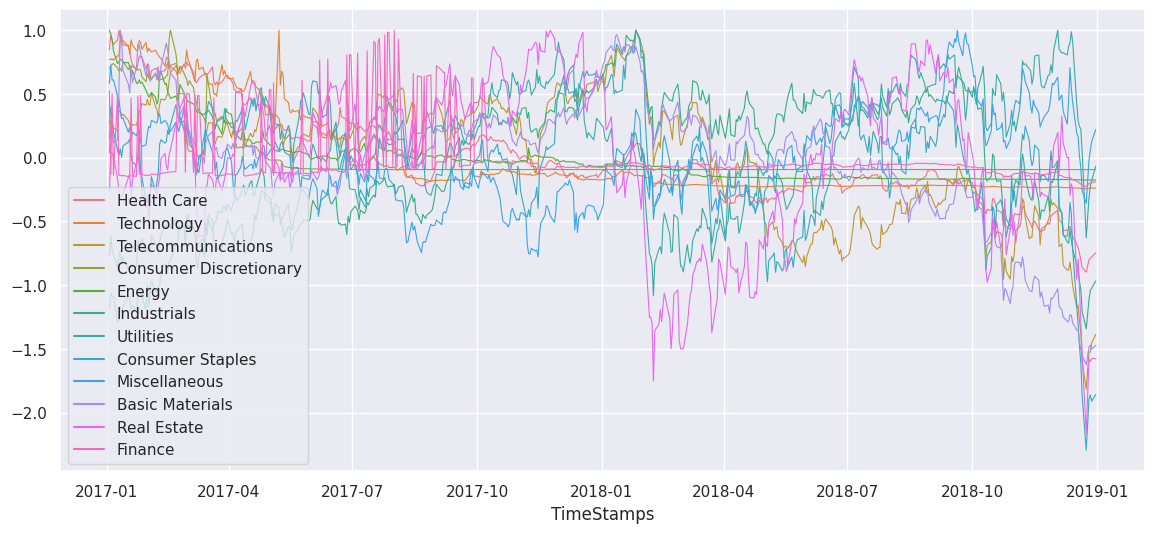

In [90]:
centralized = df_industry - df_industry.mean()
normalized = centralized / centralized.max()
# normalized = normalized.drop(columns=['Finance'])
fig = seaborn.lineplot(data=normalized, dashes=False, linewidth=0.8)
seaborn.move_legend(fig, "lower left")

We can take a look at the correlation matrix.

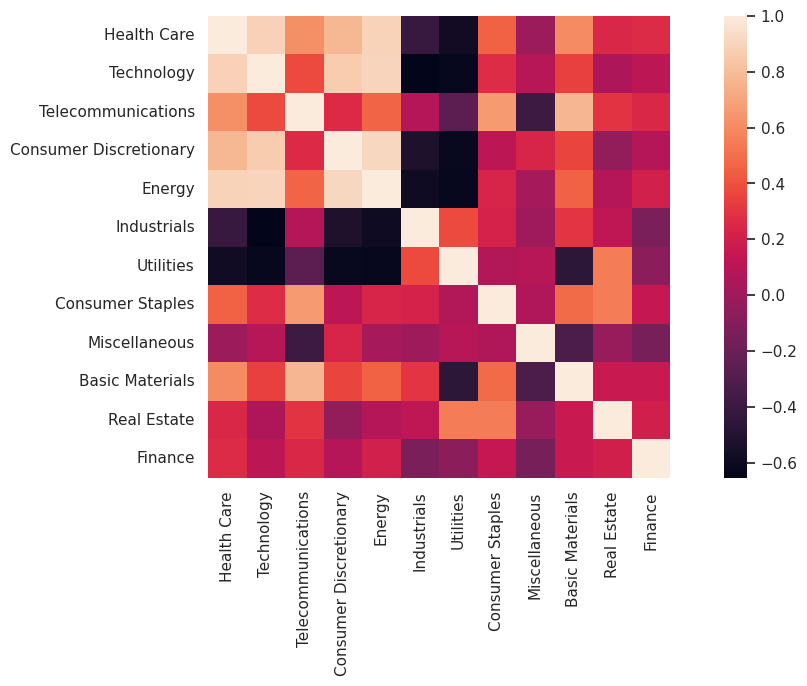

In [91]:
heatmap = seaborn.heatmap(df_industry.corr(), cbar=True, square=True)

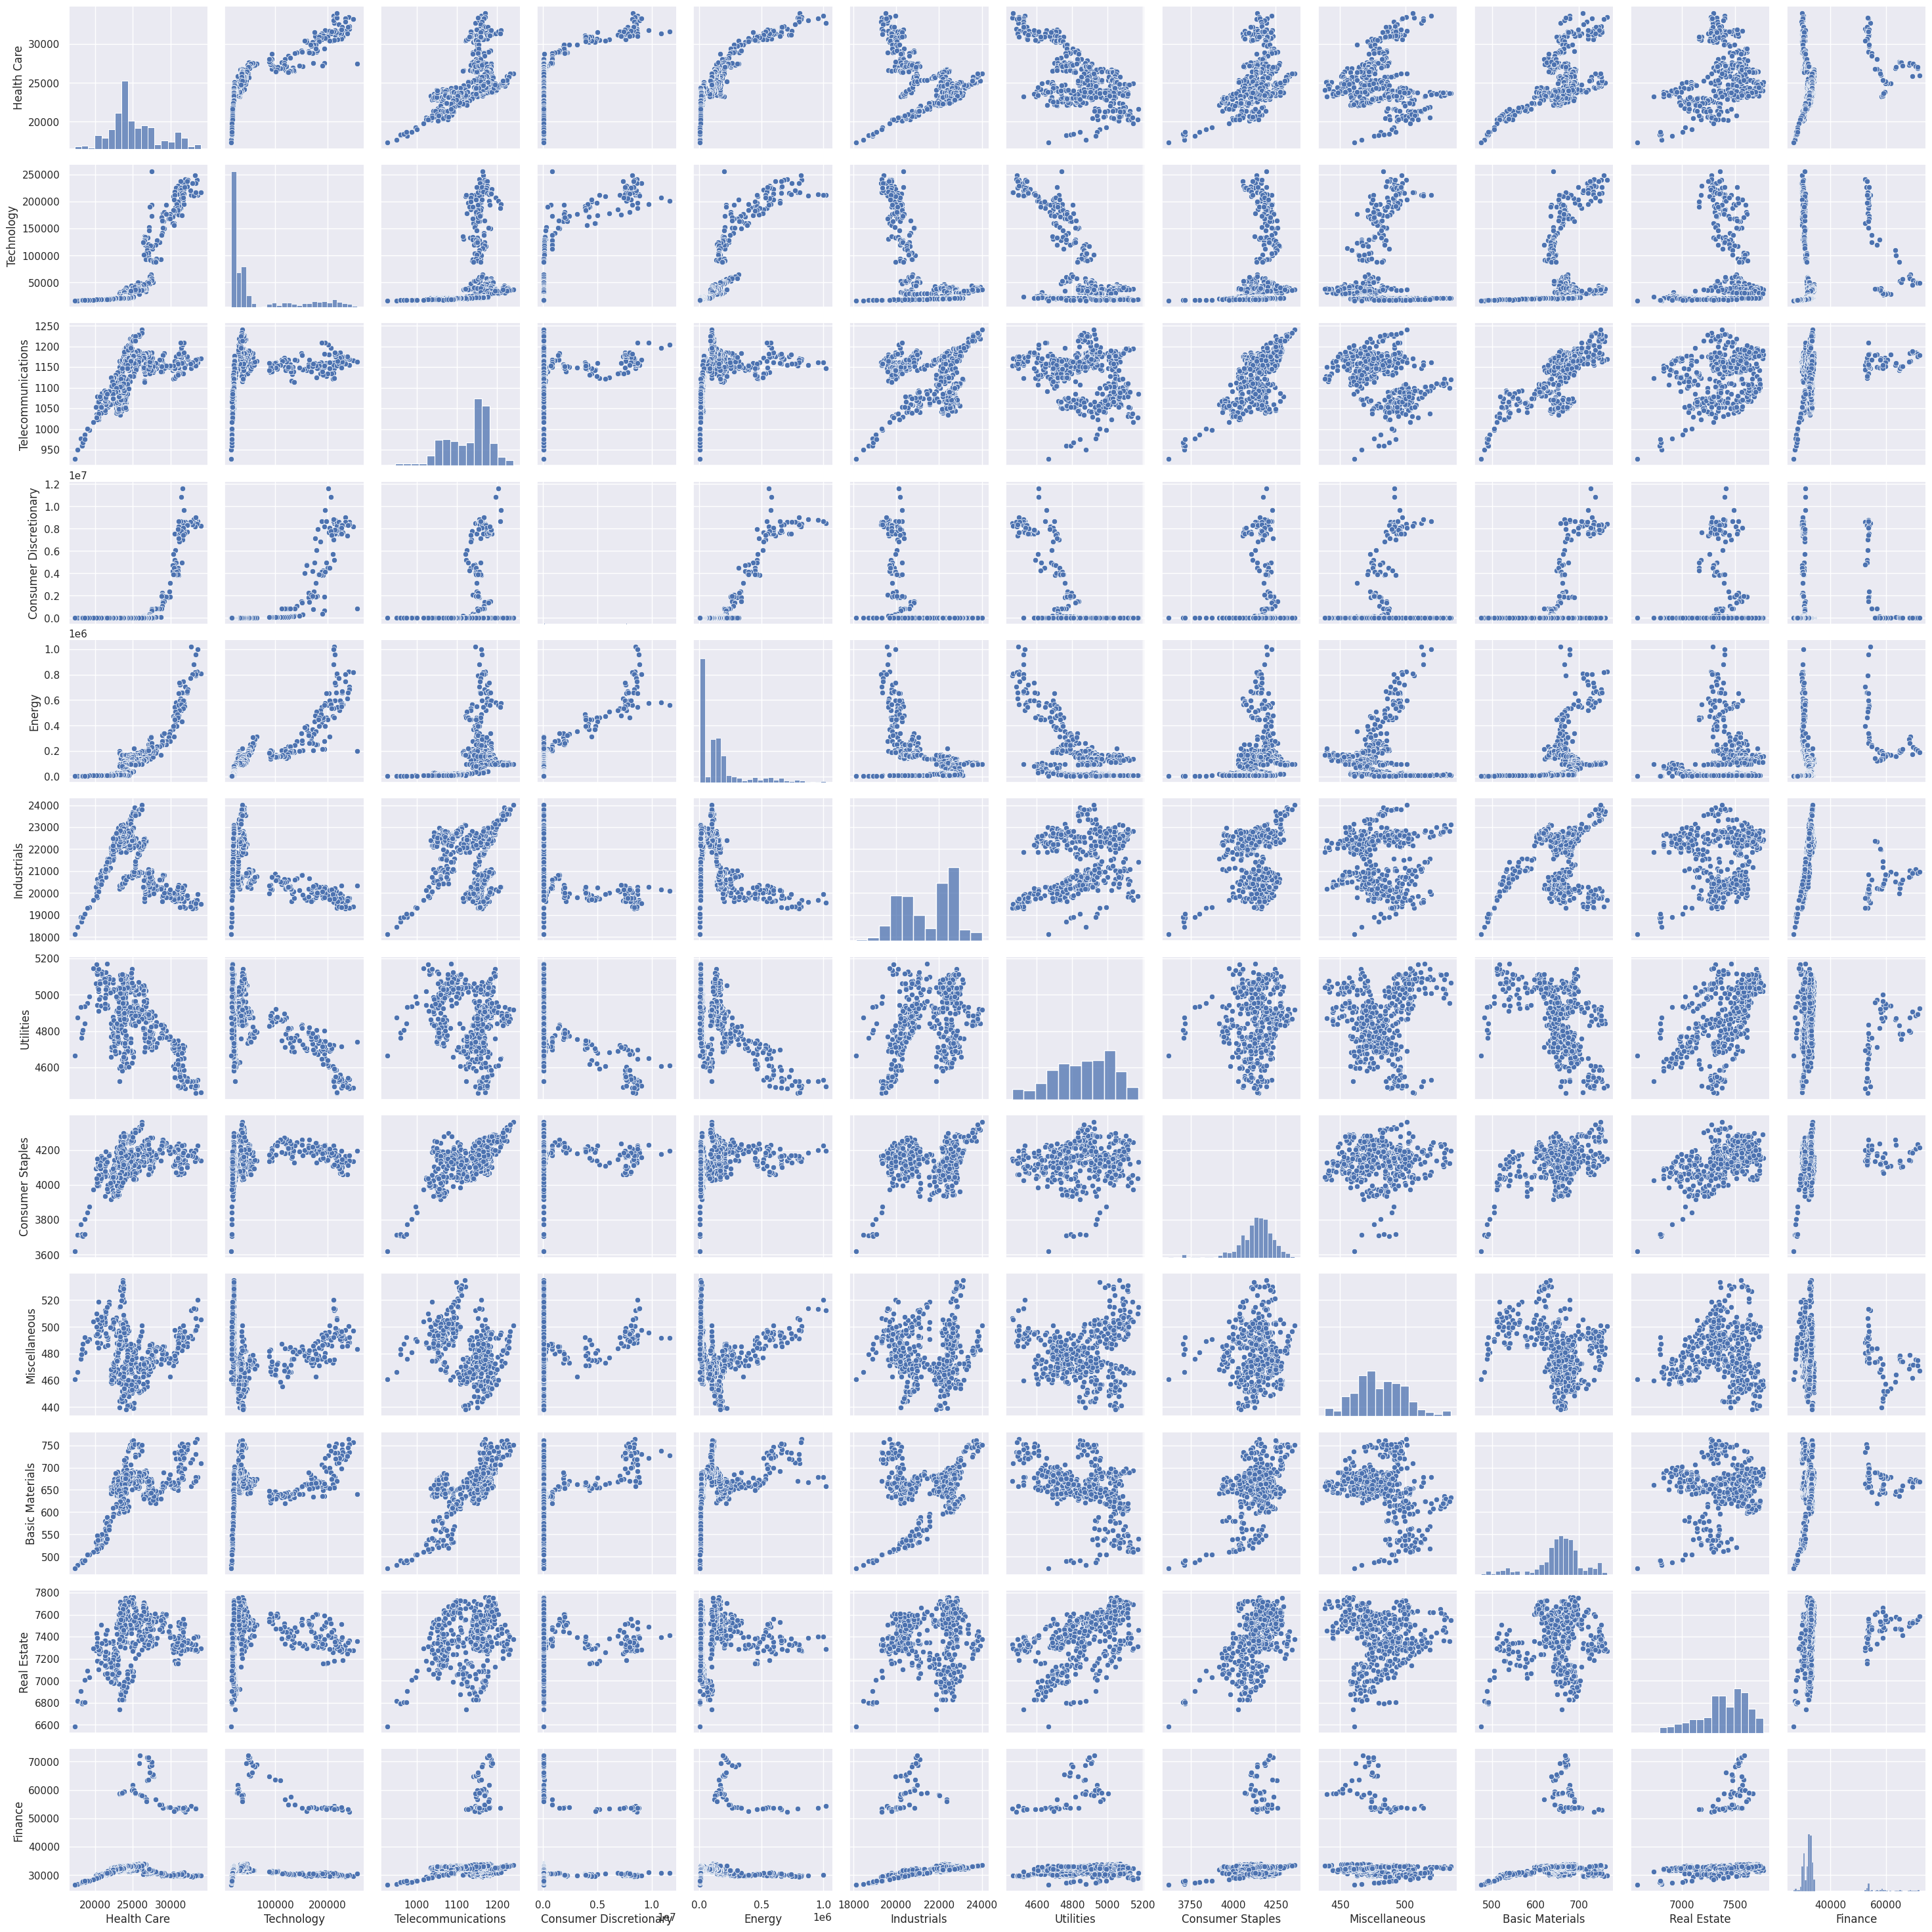

In [92]:
seaborn.pairplot(data=df_industry)

## Stock Indicators
It is rather hard to cluster stocks based on the opening and closing prices. Lets compute various statistical indicators which will be easier to handle for the clustering algorithm. We will use:
- Average return: average change in the closing price
- Return variance: variange of the change in the closing price
- Average True Range: average over day's high minus the current day's low
- Money Flow Volume: uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100.

In [93]:
stats = {}
for sym in stock_symbols:
    # return
    daily_returns = stocks[sym]['Close'].pct_change()
    annual_mean_returns = daily_returns.mean() * NOF_TRADING_DAYS

    # variance of the returns
    annual_return_variance = daily_returns.var() * NOF_TRADING_DAYS

    # average true range
    average_true_range = (stocks[sym]['High'] - stocks[sym]['Low']).mean()
    
    # money flow volume
    money_flow_volume = (((stocks[sym]['Close'] - stocks[sym]['Low']) -
                         (stocks[sym]['High'] - stocks[sym]['Close']))/ 
                        (stocks[sym]['High'] - stocks[sym]['Low'])).mean()
    
    stats[sym] = [annual_mean_returns, annual_return_variance, average_true_range, money_flow_volume]

stock_stats = pandas.DataFrame.from_dict(
    stats,
    orient='index',
    columns=['Return', 'Variance', 'Volatility', 'Money Flow']
)
stock_stats

,Return,Variance,Volatility,Money Flow
ATSG,0.229054,0.132004,0.659542,0.011832
ZEUS,-0.156550,0.223404,0.928645,-0.069190
BNED,-0.383594,0.312365,0.314729,-0.032950
DDS,0.109585,0.239939,2.722112,-0.017924
NSEC,-0.060526,0.178482,0.262928,-0.117324
...,...,...,...,...
MTT,-0.048184,0.011144,0.219761,-0.122554
UBG,0.058510,0.011239,0.024422,0.010838
ATH,-0.065894,0.052266,1.047602,-0.037728
IVZ,-0.278054,0.060886,0.623267,-0.034721


Kmeans algorithm is relative vounerable to outliers therefor I am goint to remove quantile ...

In [94]:
print(f"Number of stocks before removing outliers: {len(stock_stats)}")

for col in stock_stats.columns:
    quantile = stock_stats[col].quantile(0.99)
    stock_stats = stock_stats[stock_stats[col] < quantile]


print(f"Number of stocks after removing outliers: {len(stock_stats)}")

Number of stocks before removing outliers: 4704
Number of stocks after removing outliers: 4516


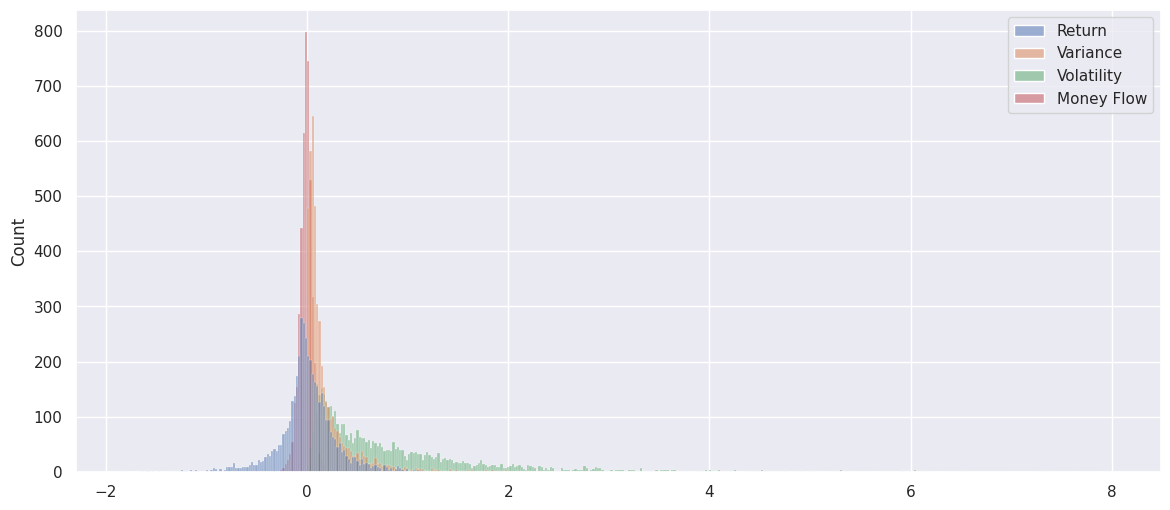

In [95]:
histogrtam = seaborn.histplot(data=stock_stats)

Reduce number of features to two using PCA

In [96]:
pca = sklearn.decomposition.PCA(n_components=2)
X = pca.fit_transform(stock_stats)

## Clustering

### K-Means Algorithm

Text(0, 0.5, 'Sum of squared distances')

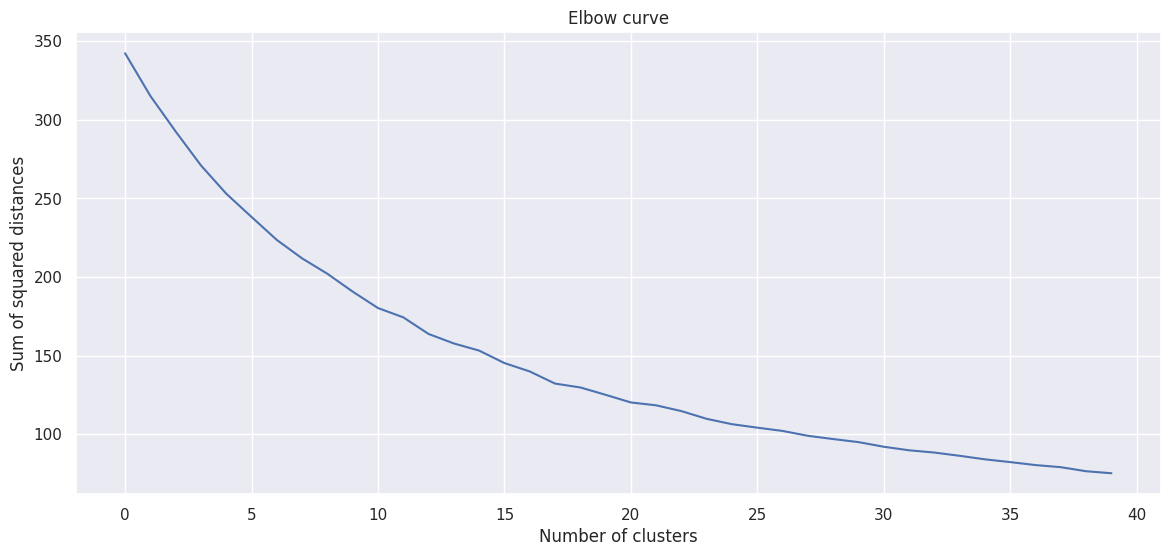

In [97]:
SSE  = []
for i in range(10, 50):
    kmeans = sklearn.cluster.KMeans(n_clusters=i)
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)

elbow_curve = seaborn.lineplot(SSE)
elbow_curve.set_title("Elbow curve")
elbow_curve.set_xlabel("Number of clusters")
elbow_curve.set_ylabel("Sum of squared distances")


Number of stocks in cluster 0: 1557
Number of stocks in cluster 1: 335
Number of stocks in cluster 2: 77
Number of stocks in cluster 3: 909
Number of stocks in cluster 4: 170
Number of stocks in cluster 5: 57
Number of stocks in cluster 6: 682
Number of stocks in cluster 7: 362
Number of stocks in cluster 8: 31
Number of stocks in cluster 9: 336


,Return,Variance,Volatility,Money Flow,Labels_kmeans
ATSG,0.229054,0.132004,0.659542,0.011832,3
ZEUS,-0.156550,0.223404,0.928645,-0.069190,3
BNED,-0.383594,0.312365,0.314729,-0.032950,7
DDS,0.109585,0.239939,2.722112,-0.017924,4
NSEC,-0.060526,0.178482,0.262928,-0.117324,0
...,...,...,...,...,...
MTT,-0.048184,0.011144,0.219761,-0.122554,0
UBG,0.058510,0.011239,0.024422,0.010838,0
ATH,-0.065894,0.052266,1.047602,-0.037728,6
IVZ,-0.278054,0.060886,0.623267,-0.034721,3


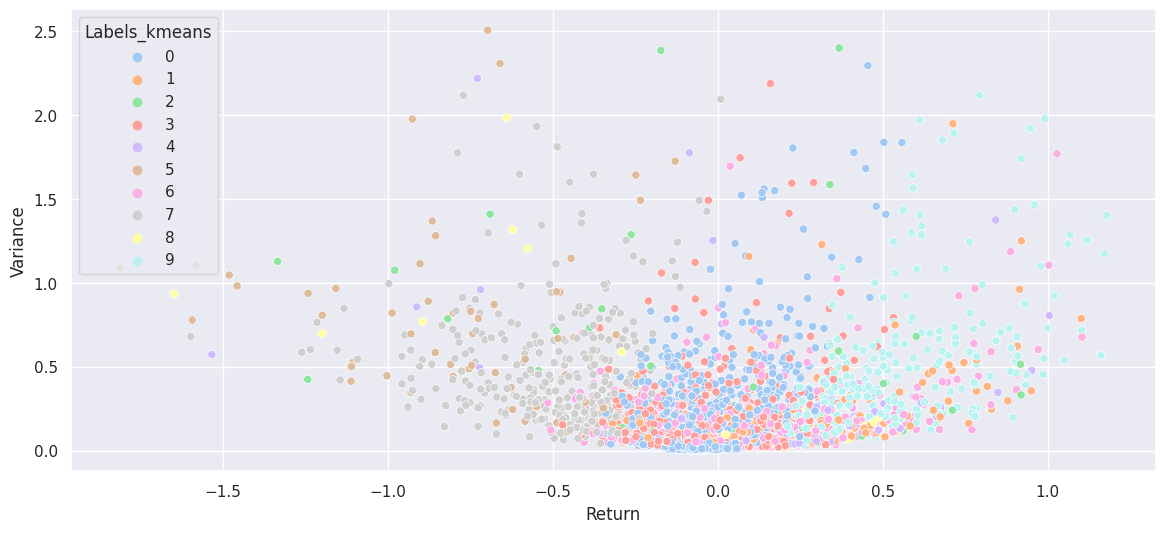

In [105]:
n_clusters = 10
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(X)
stock_stats['Labels_kmeans'] = kmeans.predict(X)

for c in range(n_clusters):
    print(f"Number of stocks in cluster {c}: {len(stock_stats[stock_stats['Labels_kmeans'] == c])}")

clusterin_plot = seaborn.scatterplot(data=stock_stats, x='Return', y='Variance', hue='Labels_kmeans', palette='pastel')
stock_stats

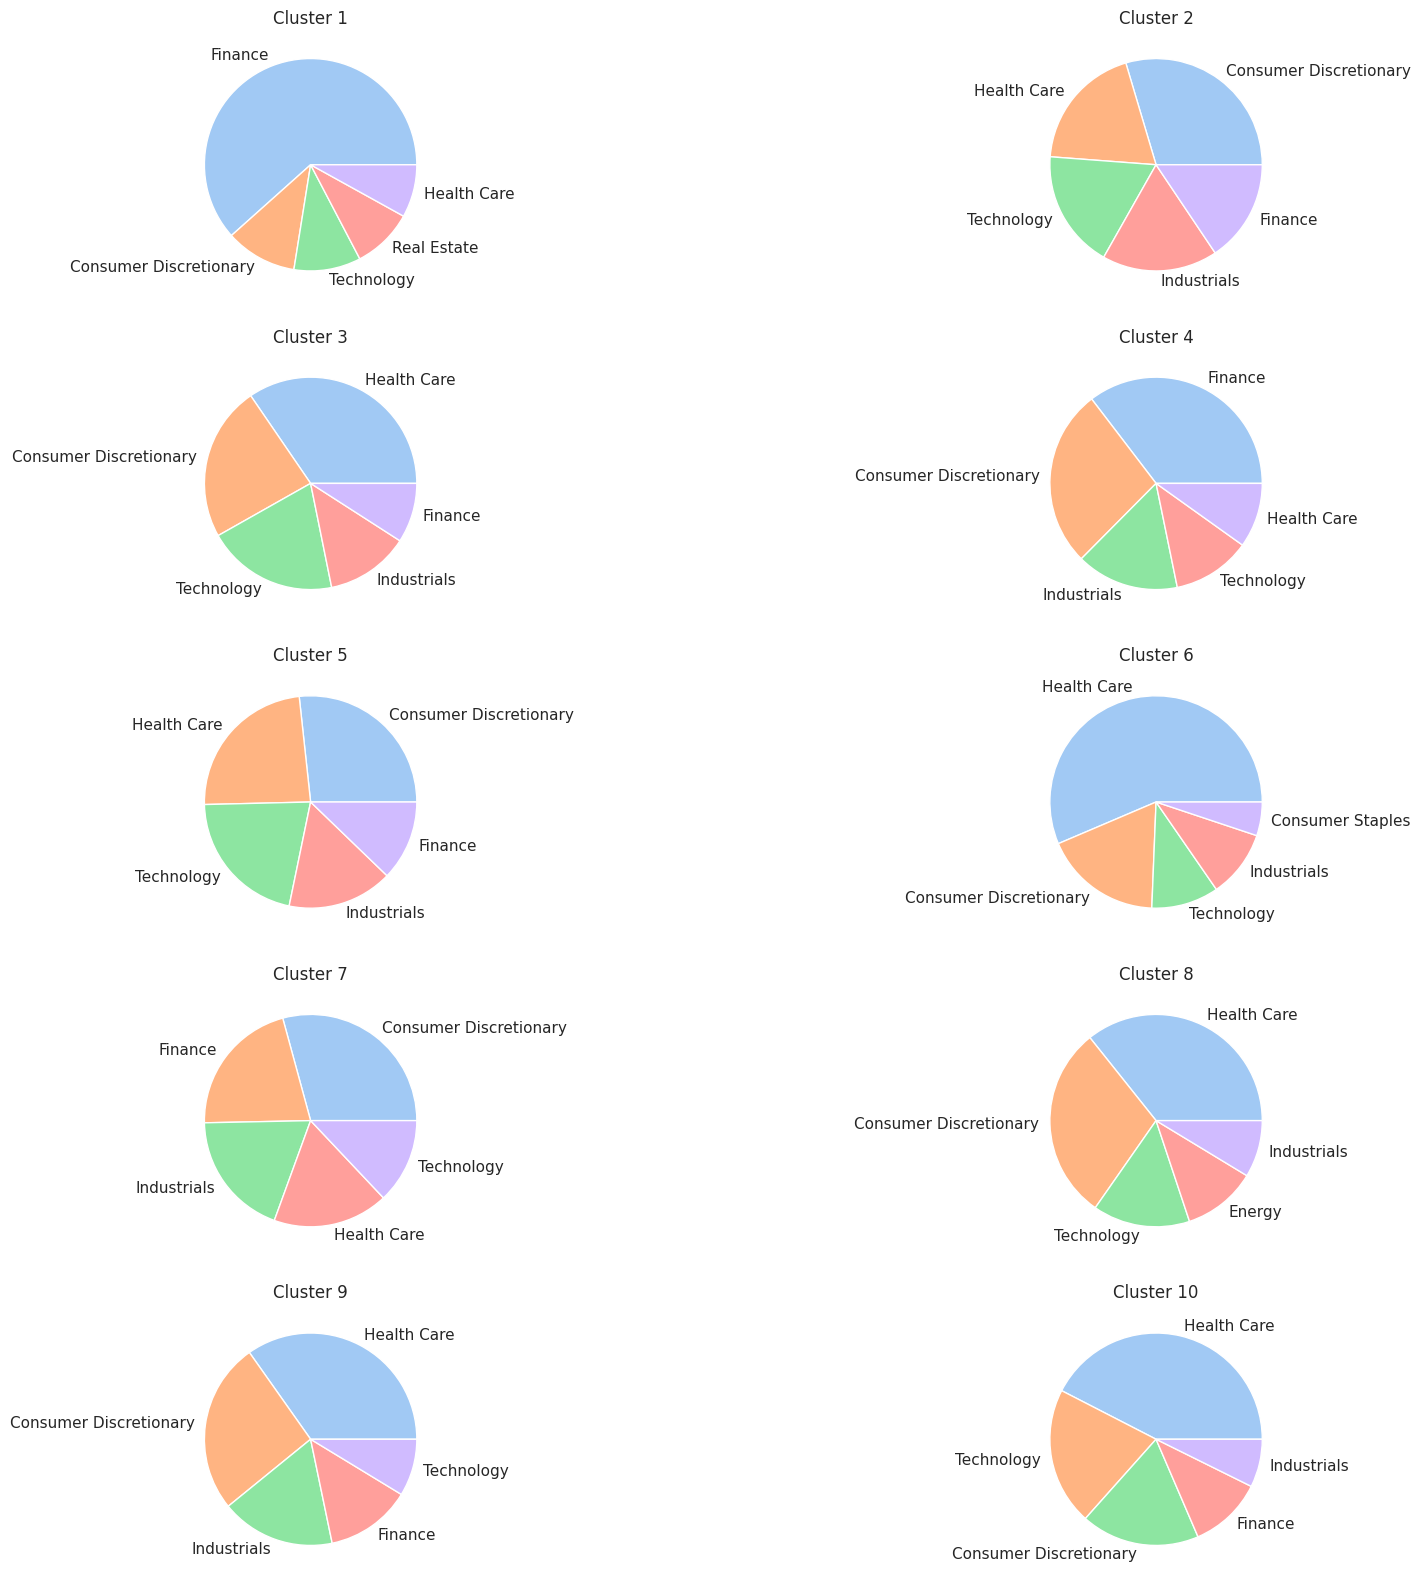

In [106]:
n_rows = 5
n_cols = n_clusters // n_rows
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

r, c = 0, 0
for i in range(n_clusters):
    if c == n_cols:
        c = 0
        r += 1
    
    sector_count = {s:0 for s in sector_names}
    for sym in stock_stats[stock_stats['Labels_kmeans'] == i].index:
        sector = screener[screener['Symbol'] == sym]['Sector'].values
        if len(sector) > 0 and isinstance(sector[0], str): 
            sector_count[sector[0]] += 1
    
    top = sorted(sector_count.items(), key=lambda x: x[1], reverse=True)[:5]
    axs[r, c].pie(x = [s[1] for s in top], labels = [s[0] for s in top], colors=seaborn.color_palette("pastel"))
    axs[r, c].set_title(f"Cluster {i+1}")
    c += 1

Number of stocks in cluster 0: 69
Number of stocks in cluster 1: 1096
Number of stocks in cluster 2: 179
Number of stocks in cluster 3: 459
Number of stocks in cluster 4: 57
Number of stocks in cluster 5: 1254
Number of stocks in cluster 6: 351
Number of stocks in cluster 7: 251
Number of stocks in cluster 8: 793
Number of stocks in cluster 9: 7


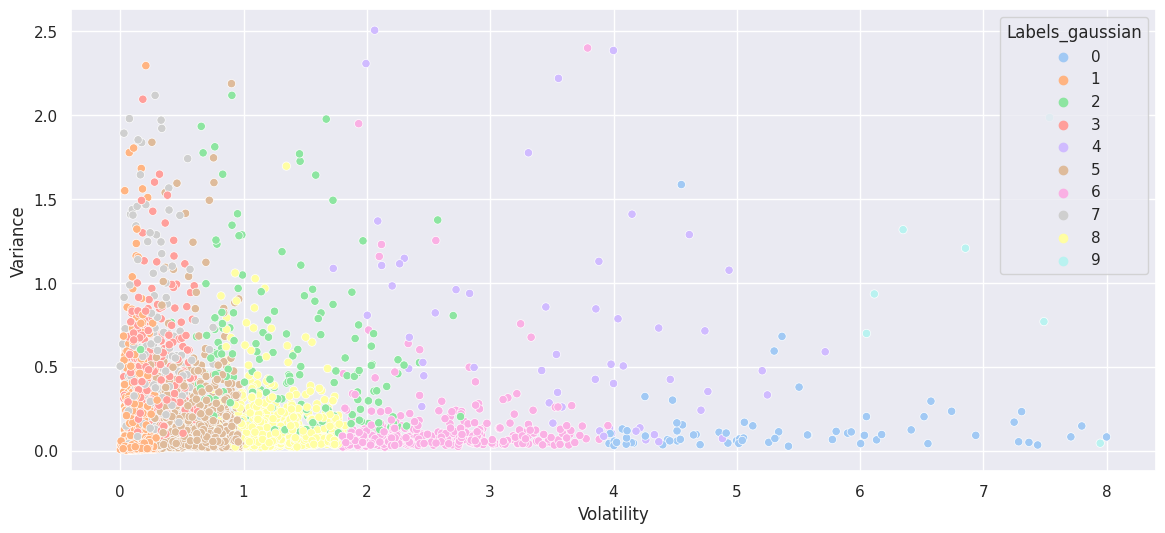

In [109]:
# X = stock_stats[['Return', 'Variance']]
n_components = 10
gaussian_mixture = sklearn.mixture.GaussianMixture(n_components=n_components)
gaussian_mixture.fit(X)
stock_stats['Labels_gaussian'] = gaussian_mixture.predict(X)

for c in range(n_components):
    print(f"Number of stocks in cluster {c}: {len(stock_stats[stock_stats['Labels_gaussian'] == c])}")

clusterin_plot = seaborn.scatterplot(data=stock_stats, x='Volatility', y='Variance', hue='Labels_gaussian', palette='pastel')

In [108]:
r, c = 0, 0
for i in range(n_clusters):
    if c == n_cols:
        c = 0
        r += 1
    
    sector_count = {s:0 for s in sector_names}
    for sym in stock_stats[stock_stats['Labels_gaussian'] == i].index:
        sector = screener[screener['Symbol'] == sym]['Sector'].values
        if len(sector) > 0 and isinstance(sector[0], str): 
            sector_count[sector[0]] += 1
    
    top = sorted(sector_count.items(), key=lambda x: x[1], reverse=True)[:5]
    axs[r, c].pie(x = [s[1] for s in top], labels = [s[0] for s in top], colors=seaborn.color_palette("pastel"))
    axs[r, c].set_title(f"Cluster {i+1}")
    c += 1